# Modular External objective function - 1D Constraint

### Written by José Hugo Elsas, Tecgraf (PUC-Rio), BR.

*Last updated Monday, 6 May 2019.*

In [1]:
%pylab inline
import GPy
import GPyOpt
from numpy.random import beta
from numpy.random import seed
from scipy.special import erf,erfc
from GPyOpt.util.general import get_quantiles
from GPyOpt.experiment_design import initial_design
from GPyOpt.acquisitions.EI import AcquisitionEI
from GPyOpt.methods import ModularBayesianOptimization

Populating the interactive namespace from numpy and matplotlib


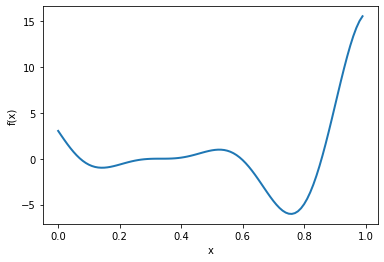

In [2]:
# --- Function to optimize
func = GPyOpt.objective_examples.experiments1d.forrester() 
func.plot()

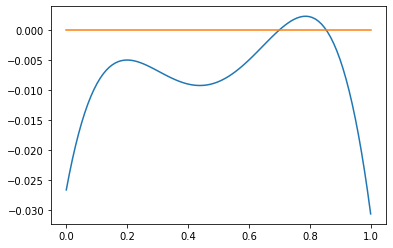

In [3]:
# Desired constraint
x = np.linspace(0,1.0,100)
plt.plot(x,-x*(0.4-x)*(x-0.6)*(0.9-x)+0.04*(x-0.6)*(0.9-x)-0.005)
plt.plot(x,np.zeros(x.shape))

In [4]:
def g(x):
    return (-x*(0.4-x)*(x-0.6)*(0.9-x)+0.04*(x-0.6)*(0.9-x)-0.005)

In [5]:
objective = GPyOpt.core.task.SingleObjective(func.f)

In [6]:
def test_constraint(x):
    return -x*(0.4-x)*(x-0.6)*(0.9-x)-0.0025

In [7]:
constraint = test_constraint

In [8]:
space = [{'name': 'var1', 'type': 'continuous', 'domain': (0,1)}]
space = GPyOpt.Design_space(space = space)

In [9]:
model = GPyOpt.models.GPModel(optimize_restarts=5,verbose=False)

In [10]:
model_c = [GPyOpt.models.GPModel(optimize_restarts=5,verbose=False)]

In [11]:
aquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(space)

In [12]:
acquisition = AcquisitionEI(model,space,optimizer=aquisition_optimizer,jitter=0.0,model_c=model_c,jitter_c=np.array([0]))

In [13]:
# --- CHOOSE a collection method
evaluator = GPyOpt.core.evaluators.Sequential(acquisition)

In [14]:
X_init = np.array([[0.0],[0.5],[1.0]])
Y_init = func.f(X_init)

In [15]:
print(X_init)
print(Y_init)

[[0. ]
 [0.5]
 [1. ]]
[[ 3.02720998]
 [ 0.90929743]
 [15.82973195]]


In [16]:
C_init = np.empty(Y_init.shape)
for i in range(X_init.shape[0]):
    print(g(X_init[i]))
    C_init[i,:] = g(X_init[i])

[-0.0266]
[-0.0086]
[-0.0306]


In [17]:
print(C_init)

[[-0.0266]
 [-0.0086]
 [-0.0306]]


In [18]:
iter_count = 20
current_iter = 0
X_step = X_init
Y_step = Y_init
C_step = C_init

In [19]:
print(Y_step)

[[ 3.02720998]
 [ 0.90929743]
 [15.82973195]]


In [20]:
print(type(Y_step),Y_step.dtype,Y_step.shape)
print(type(C_step),C_step.dtype,C_step.shape)

<class 'numpy.ndarray'> float64 (3, 1)
<class 'numpy.ndarray'> float64 (3, 1)


In [21]:
while current_iter < iter_count:
    print("Current iteration - ",current_iter)
    bo_step = ModularBayesianOptimization(model, space, objective, acquisition, evaluator, 
                                          X_init = X_step, Y_init = Y_step, C_init = C_step, 
                                          model_c = model_c, normalize_Y = False)
    
    x_next = bo_step.suggest_next_locations()
    y_next = func.f(x_next)
    c_next = g(x_next)
    print(x_next,y_next,c_next)
    
    X_step = np.vstack((X_step, x_next))
    Y_step = np.vstack((Y_step, y_next))
    C_step = np.vstack((C_step, c_next))
    
    current_iter += 1

Current iteration -  0
[[0.]] [[3.02720998]] [[-0.0266]]
Current iteration -  1
[[0.33519205]] [[2.77388403e-06]] [[-0.00773359]]
Current iteration -  2
[[0.70870033]] [[-4.96309821]] [[0.00038108]]
Current iteration -  3
[[0.70861478]] [[-4.95975848]] [[0.00037744]]
Current iteration -  4
[[0.74527136]] [[-5.94686495]] [[0.00168307]]
Current iteration -  5
[[0.76722137]] [[-5.96618435]] [[0.00214373]]
Current iteration -  6
[[0.75725318]] [[-6.02074005]] [[0.00197061]]
Current iteration -  7
[[0.18794089]] [[-0.74952307]] [[-0.00504267]]
Current iteration -  8
[[0.75685799]] [[-6.0206586]] [[0.00196246]]
Current iteration -  9
[[0.75738953]] [[-6.02072947]] [[0.0019734]]
Current iteration -  10
[[0.75729924]] [[-6.02073869]] [[0.00197156]]
Current iteration -  11
[[0.7581949]] [[-6.02026074]] [[0.00198966]]
Current iteration -  12
[[0.75842202]] [[-6.02000253]] [[0.00199417]]
Current iteration -  13
[[0.75709138]] [[-6.02072684]] [[0.00196729]]
Current iteration -  14
[[0.75722993]] [

In [22]:
print(X_step.shape,C_step.shape,C_step.shape)

(23, 1) (23, 1) (23, 1)


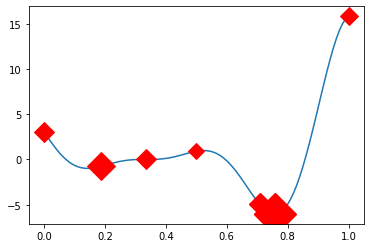

In [23]:
x = np.arange(0.0, 1.0, 0.01)
y = func.f(x)

plt.figure()
plt.plot(x, y)
for i, (xs, ys) in enumerate(zip(X_step, Y_step)):
    plt.plot(xs, ys, 'rD', markersize=10 + 20 * (i+1)/len(X_step))

0.0002243677073199667
3836.589386860568
0.7621209234157605
0.22316268549621193
0.06158066615062932
0.015141617345325206
0.005662694335686807
0.000170981030518894
1.3643191460499547e-09
2.3599076548928354e-13
4.770803593553254e-16
4.0013026821134113e-16
1.8915826561124674e-17
1.1195121090968597e-17
1.060728498405242e-17
1.0498594635336368e-17
1.0233497714462235e-17
1.0096653846466797e-17
5.561339074927646e-18
5.327139544972119e-18
5.195052309871144e-18


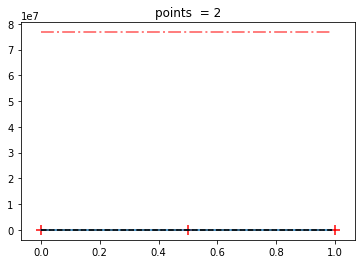

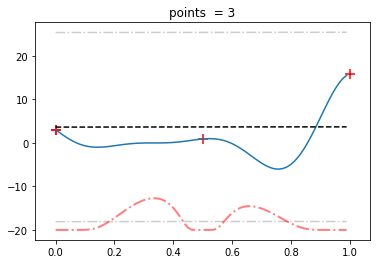

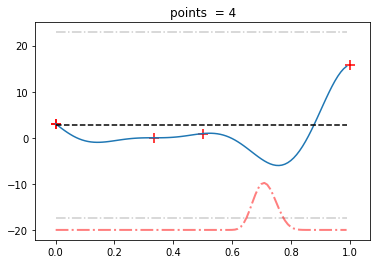

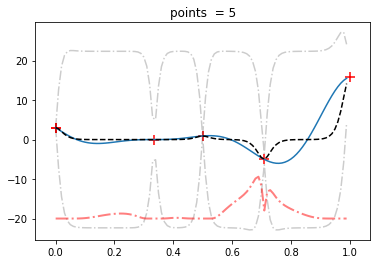

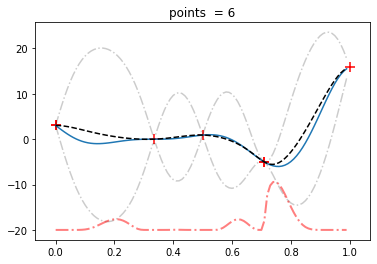

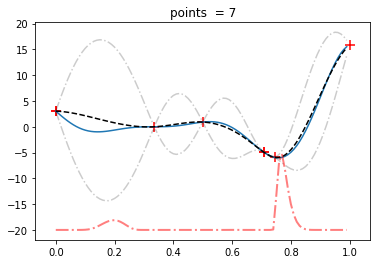

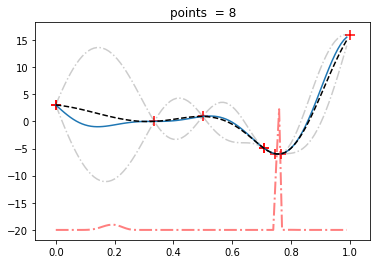

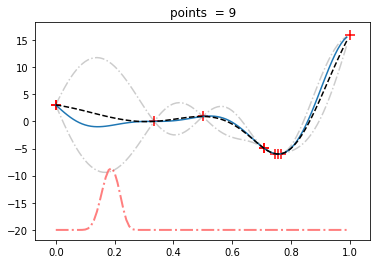

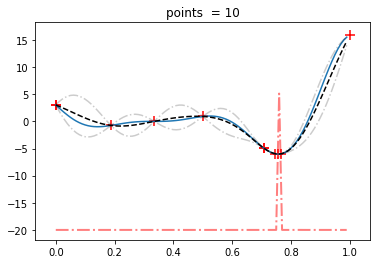

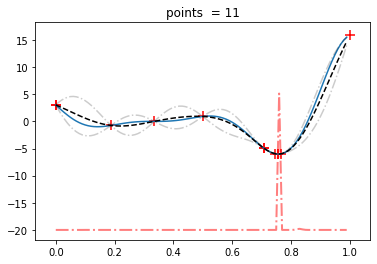

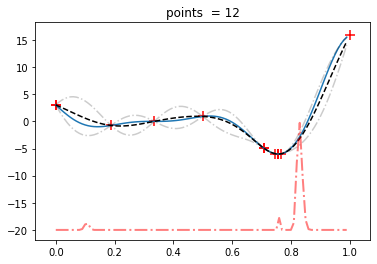

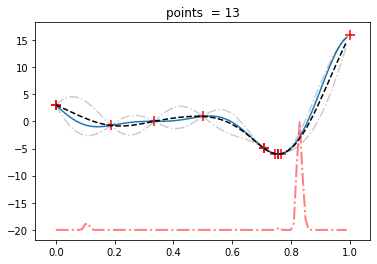

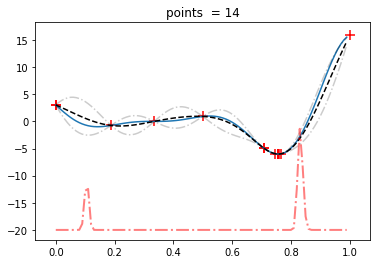

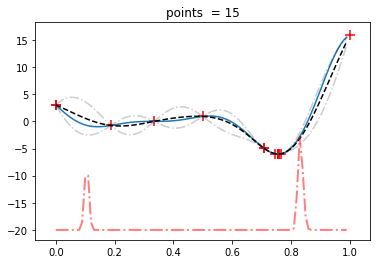

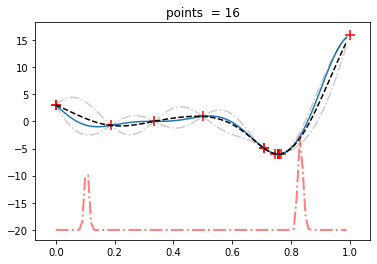

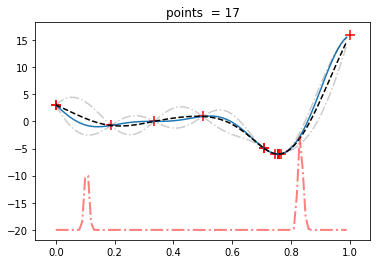

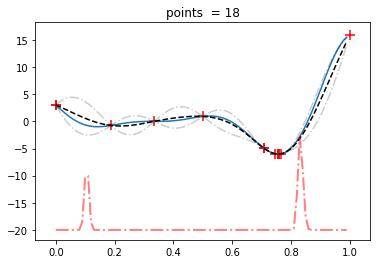

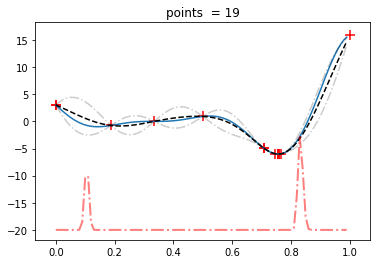

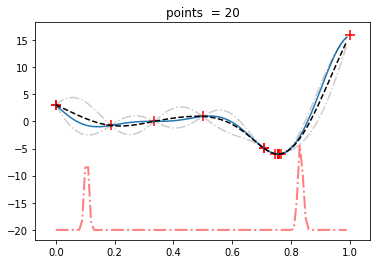

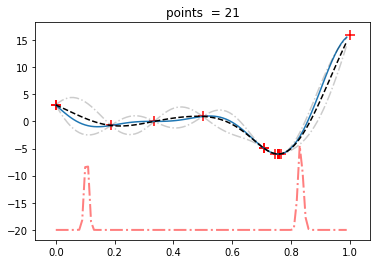

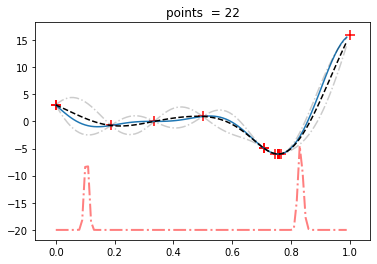

In [25]:
for n in range(3,X_step.shape[0]+1):
    bo_step = ModularBayesianOptimization(model, space, objective, acquisition, evaluator, 
                                          X_init = X_step, Y_init = Y_step, C_init = C_step, 
                                          model_c = model_c, normalize_Y = False)
    
    
    model.updateModel(X_step[0:n,:],Y_step[0:n,:],None,None)
    model_c[0].updateModel(X_step[0:n,:],C_step[0:n,:],None,None)
    
    m,v = model.model.predict(x[:,np.newaxis])
    
    acq = bo_step.acquisition.acquisition_function(x[:,np.newaxis])
    
    print(np.std(acq))
    
    fig = plt.figure()
    plt.title("points  = "+str(n-1))
    plt.plot(x, y)
    plt.scatter(X_step[0:n,:],Y_step[0:n,:],marker='+',s=120,c='r')
    
    plt.plot(x,m,'k--')
    plt.plot(x,m-2.96*np.sqrt(v),'k-.', alpha=0.2)
    plt.plot(x,m+2.96*np.sqrt(v),'k-.', alpha=0.2)
        
    plt.plot(x,-2.5*(acq/np.std(acq))-20, 'r-.',lw=2,label ='Acquisition (arbitrary units)',alpha=0.5)